## Install and Import Dependencies

Before starting PyTorch needs to be installed in the machine from terminal from the link https://pytorch.org/get-started/locally/

In [1]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
!pip install easyocr
!pip install imutils

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Importing Required Libraries
cv2: OpenCV library for computer vision tasks like image processing and object detection.

matplotlib.pyplot: Used for displaying images and plots in a Jupyter notebook or Python script.

numpy: Essential for handling arrays and performing numerical operations on image data.

imutils: Convenience functions to simplify OpenCV operations like resizing, rotating, and translating images.

easyocr: A ready-to-use Optical Character Recognition (OCR) library that can recognize text in multiple languages with deep learning.

These libraries together form the foundation for building and visualizing OCR-based applications, such as license plate recognition or scene text detection.

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr

## Read in Image, Grayscale

Loading and Displaying the Original Image
The image 'Towhid.jpg' is loaded using cv2.imread().

OpenCV loads images in BGR format by default, so it's converted to RGB using cv2.cvtColor() for correct color display in matplotlib.

plt.imshow() is then used to display the image inline.

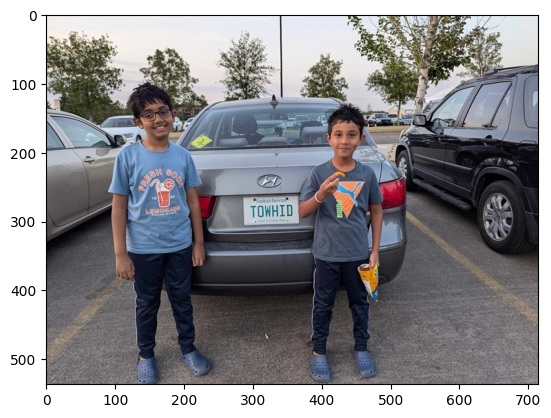

In [2]:
# Loading and showing the original image
image = cv2.imread('Towhid.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

Converting to Grayscale and Displaying
The original RGB image is converted to grayscale using cv2.cvtColor() with the cv2.COLOR_BGR2GRAY flag.

The grayscale image is displayed using matplotlib. It's converted back to RGB for proper visualization in the plot (grayscale images in OpenCV are single-channel, but matplotlib expects 3 channels for color).

This step simplifies the image for further processing like edge detection or OCR.









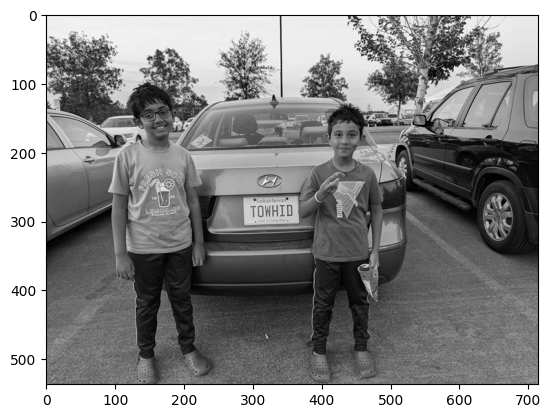

In [3]:
# Converting the image to grayscale and showing it
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
plt.show()

## Apply filter and find edges for localization

Noise Reduction with Bilateral Filter
A bilateral filter is applied to the grayscale image using cv2.bilateralFilter().

It smooths the image while preserving edges, which is essential for accurate contour and text detection.

Parameters used:

10: Diameter of each pixel neighborhood.

20: Filter sigma in the color space.

20: Filter sigma in the coordinate space.

The filtered image is displayed using matplotlib after converting it back to RGB for visualization.

This step helps reduce noise without blurring important features like edges and text.

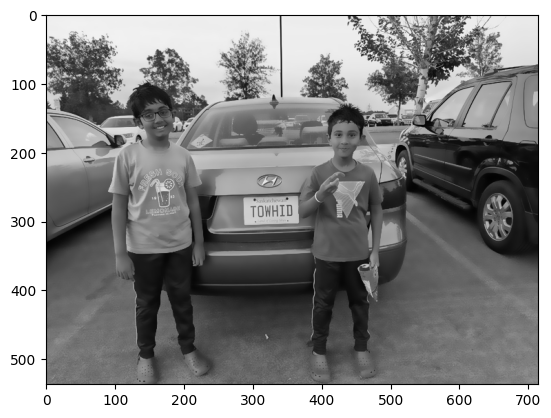

In [4]:
# Applying bilateral filter to reduce noise and showing it
bfilter = cv2.bilateralFilter(gray, 10, 20, 20) #Noise reduction (Diameter of Pixel Neighborhood, SigmaColor, SigmaSpace)
plt.imshow(cv2.cvtColor(bfilter, cv2.COLOR_BGR2RGB))
plt.show()

Edge Detection using Canny Algorithm
After noise reduction, Canny edge detection is applied to highlight the edges in the image using cv2.Canny().

Parameters used:

50: First threshold for the hysteresis procedure (lower bound).

200: Second threshold (upper bound).

This step is crucial for detecting the boundaries of objects like license plates or text regions.

The resulting edge-detected image is then visualized using matplotlib.

Edge detection helps isolate key features of interest, especially when identifying license plate contours.

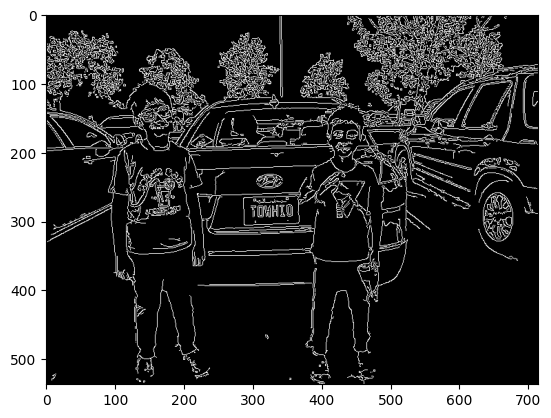

In [5]:
# Applying Canny edge detection and showing it
edged = cv2.Canny(bfilter, 50, 200) #Edge detection (Threshold1, Threshold2)
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))
plt.show()

## Find Contours and Apply Mask

Finding Contours in the Image
The cv2.findContours() function is used to detect contours in the edge-detected image.

cv2.RETR_TREE: Retrieves all of the contours and reconstructs a full hierarchy of nested contours.

cv2.CHAIN_APPROX_SIMPLE: Compresses horizontal, vertical, and diagonal segments and leaves only their end points, saving memory.

imutils.grab_contours() is used to handle compatibility across different OpenCV versions.

The contours are sorted by area in descending order.

Only the top 10 largest contours are selected for further processing, as the license plate is likely among the biggest rectangular regions in the image.

This step prepares for identifying the exact region containing the license plate.

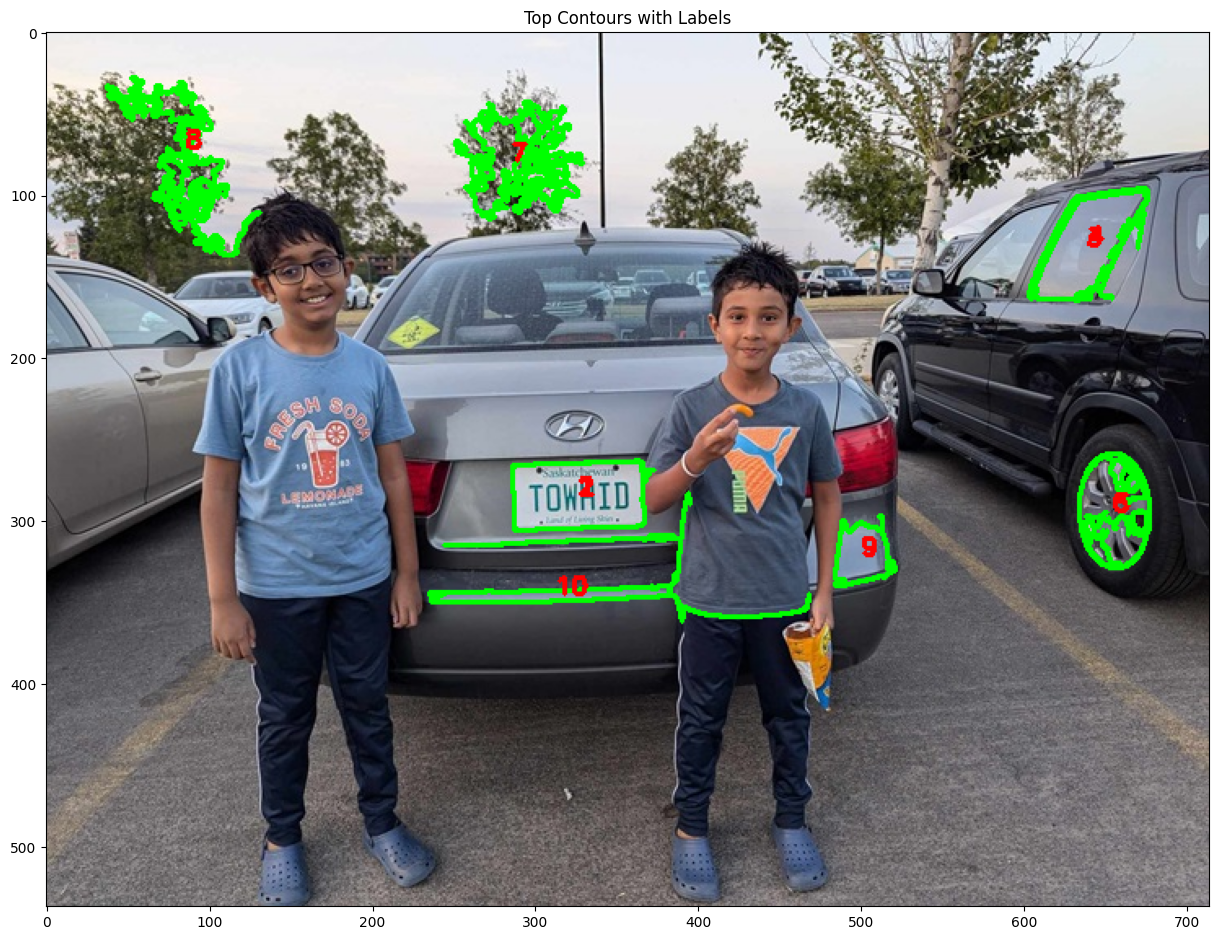

In [6]:
# Finding contours in the edged image
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Handle compatibility across different OpenCV versions
contours = imutils.grab_contours(keypoints)

# Sorting contours based on area and keeping few
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

# Make a copy of the original image for drawing
image_copy = image.copy()

# Draw and label the top contours
for i, contour in enumerate(contours):
    # Draw the contour
    color = (0, 255, 0)  # Green color for the contour
    thickness = 2  # Line thickness
    cv2.drawContours(image_copy, [contour], -1, color, thickness)
    
    # Calculate the center of the contour
    M = cv2.moments(contour)
    if M["m00"] != 0:  # To avoid division by zero
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = 0, 0
    
    # Label the contour with its index
    cv2.putText(image_copy, f"{i+1}", (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

# Display contours with labels
plt.figure(figsize=(15, 12))  # Adjust the figure size to show the image and contours clearly
plt.imshow(image_copy)
plt.title("Top Contours with Labels")
plt.show()



Approximating Contours and Identifying 
License Plate Location
A loop iterates through the sorted contours to find the contour that most likely corresponds to a license plate.

cv2.approxPolyDP() is used to approximate the shape of each contour.

The parameter 10 determines the accuracy of the approximation (epsilon); smaller values result in more accurate approximations.

A license plate is generally a rectangle, so we check if the approximated contour has 4 sides.

Once a 4-sided contour is found, it is stored in the variable location and the loop breaks.

This contour is considered the most likely location of the license plate.

What is location?

location contains the approximated coordinates of a 4-sided contour (like a rectangle).

This is assumed to be the license plate region, based on the shape (since most plates are rectangular).

In [7]:
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break

# Print the location of the detected contour
location

array([[[373, 269]],

       [[287, 266]],

       [[287, 305]],

       [[366, 303]]], dtype=int32)

 Description of License Plate Masking and Isolation

In this section, we isolate the license plate from the image using a mask based on the detected contour (location).

Steps:

Create a blank mask the same size as the grayscale image.

Draw the detected license plate contour (location) onto the mask in white (255).

Use bitwise AND to extract only the region of interest (ROI) from the original image — i.e., the license plate


This displays only the license plate area extracted from the original image.

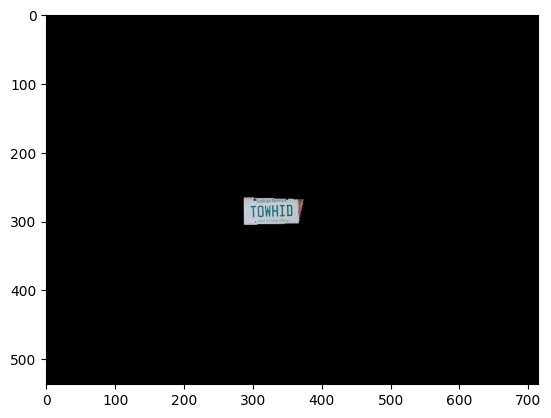

In [8]:
# Draw the detected contour
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0,255, -1)
new_image = cv2.bitwise_and(image, image, mask=mask)

# Display the masked image
plt.imshow(new_image)
plt.show()

np.where(mask == 255) finds all coordinates where the mask is present (i.e., the plate area).

np.min and np.max determine the bounding box around the plate.

gray[x1:x2+1, y1:y2+1] slices the grayscale image to get the license plate region.

This cropped_image will be ready for OCR or further enhancement.

Cropping and Displaying the License Plate

After detecting the license plate's location, we crop the license plate region from the grayscale image using the mask. The final step here is to display the cropped plate to visually confirm successful extraction.

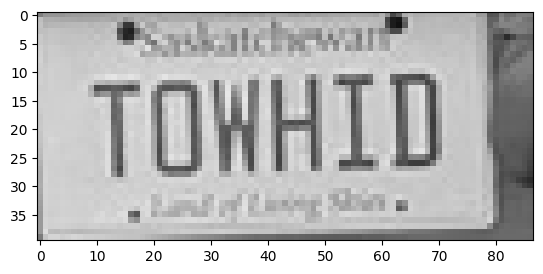

In [9]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

# Display the cropped image
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
plt.show()

## Use Easy OCR To Read Text

 Performing OCR with EasyOCR
 
After successfully isolating and cropping the license plate region, we use EasyOCR to extract the text (license plate number) from the image.

In [10]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
result

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[np.int32(6), np.int32(6)],
   [np.int32(74), np.int32(6)],
   [np.int32(74), np.int32(32)],
   [np.int32(6), np.int32(32)]],
  'towhid',
  np.float64(0.9620178814044659))]

## Render Result

Displaying Detected License Plate Text on Image

After extracting the license plate number using OCR, this code overlays the recognized text back onto the original image and highlights the license plate region with a rectangle.

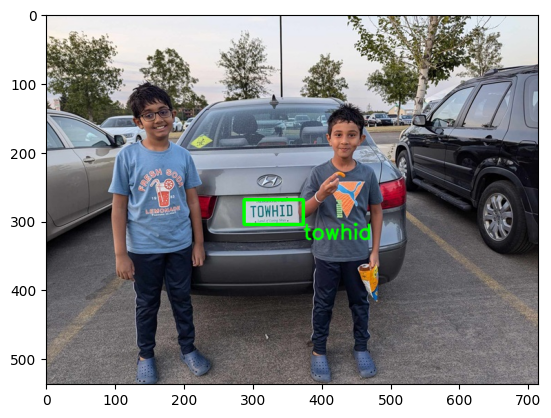

In [11]:
text = result[0][-2]
font = cv2.FONT_HERSHEY_SIMPLEX
res = cv2.putText(image, text=text, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
res = cv2.rectangle(image, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)
plt.imshow(res)
plt.show()

**So we can see the number plate has been recognized and converted to text**

## Now we will wrap all the previous code blocks under one function for easy use

In [18]:
# Importing necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
import easyocr

def recognize_number_plate(image_path):
    # Load and convert the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Step-by-step preprocessing
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    bfilter = cv2.bilateralFilter(gray, 10, 20, 20)
    edged = cv2.Canny(bfilter, 50, 200)
    
    # Find contours and select the one that likely represents the plate
    keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(keypoints)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

    location = None
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 10, True)
        if len(approx) == 4:
            location = approx
            break

    if location is None:
        print("No number plate contour found.")
        return

    # Mask and crop the number plate region
    mask = np.zeros(gray.shape, np.uint8)
    new_image = cv2.drawContours(mask, [location], 0,255, -1)
    new_image = cv2.bitwise_and(image, image, mask=mask)
    (x,y) = np.where(mask==255)
    (x1, y1) = (np.min(x), np.min(y))
    (x2, y2) = (np.max(x), np.max(y))
    cropped_image = gray[x1:x2+1, y1:y2+1]

    # Use EasyOCR to read text
    reader = easyocr.Reader(['en'])
    result = reader.readtext(cropped_image)

    if result:
        text = result[0][-2]
        # Annotate the image with the detected number plate
        font = cv2.FONT_HERSHEY_SIMPLEX
        res = cv2.putText(image.copy(), text, org=(approx[0][0][0], approx[1][0][1]+60),
                          fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
        res = cv2.rectangle(res, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)
    else:
        text = "No text detected"
        res = image

    # Display input and output images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title(f"Detected Plate: {text}")
    plt.imshow(res)
    plt.axis('off')
    plt.show()


## Using of the function

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


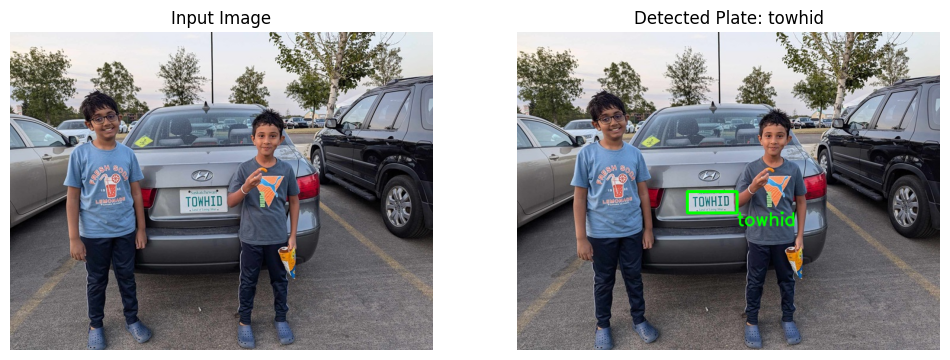

In [19]:
# Call the function with the image path
recognize_number_plate('towhid.jpg')

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


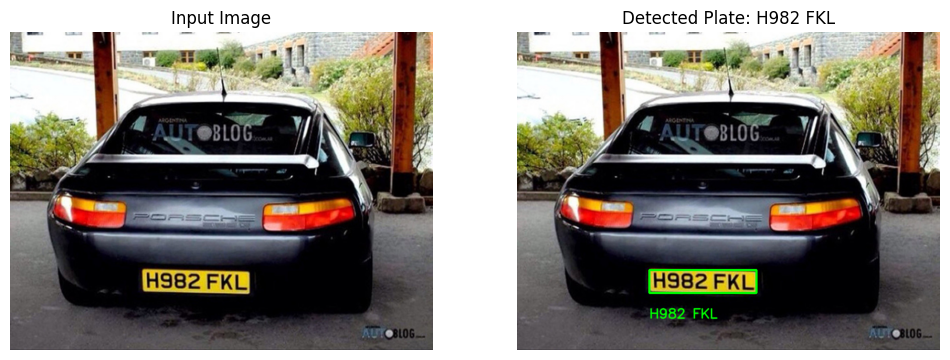

In [20]:
# Test with a different image
recognize_number_plate('porsche.jpg')


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


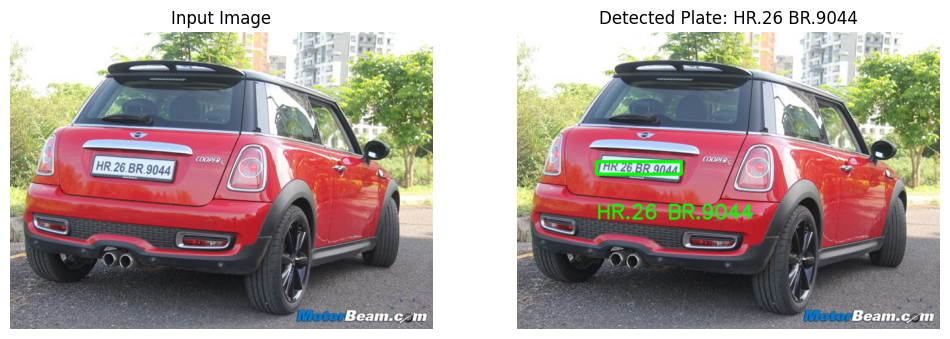

In [21]:
# Test with a different image
recognize_number_plate('cooper.jpg')

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


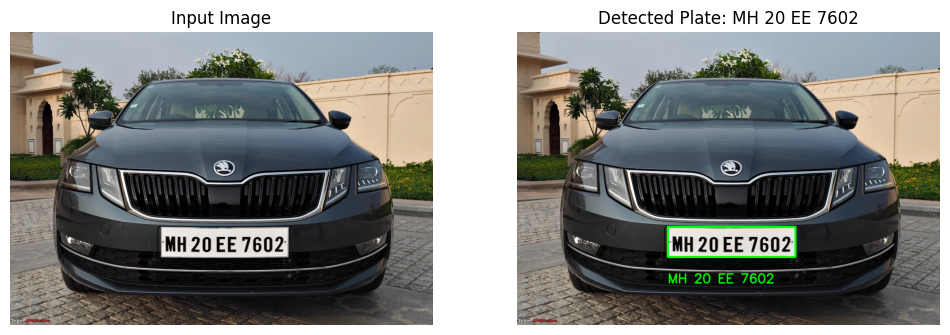

In [22]:
# Test with a different image
recognize_number_plate('black_car.jpg')

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


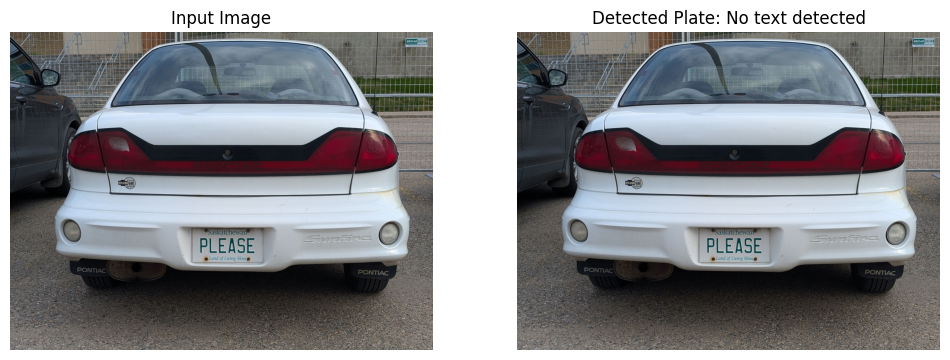

In [23]:
# Test with a different image
recognize_number_plate('PXL_20240916_145318607.jpg')

**From the above testing we can see our system can detect number plate successfully in most of the cases. But not in all cases.**

There are some limitations present.

If the color variation around the number plate isn't that much or if the image is tilted or angled (if number plate isn't in approximate rectangular shape) our system can't recognize the plate properly.

This number plate recognition project successfully demonstrates a basic end-to-end pipeline using OpenCV and EasyOCR. The combination of traditional image processing and deep learning-based OCR allows for reasonably accurate detection and reading of vehicle plates. With further enhancements, such as plate orientation correction, improved preprocessing, and support for multiple detections, this system could be scaled for real-time applications in smart city infrastructure.